In [1]:
tissue = "nose"

# Dask params
n_workers = 4
dask_chunk_size = 80_000
threads_per_worker = None
dashboard_port = 8786

In [2]:
from dask.distributed import Client, LocalCluster

if n_workers is None:
    n_workers = cpu_count() // threads_per_worker
cluster = LocalCluster(
    n_workers=n_workers,
    threads_per_worker=threads_per_worker,
    dashboard_address=f":{dashboard_port}",
)
print(f"{n_workers=}, {threads_per_worker=}")
client = Client(cluster)

client

n_workers=4, threads_per_worker=None


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8786/status,
Dashboard: http://127.0.0.1:8786/status,Workers: 4
Total threads: 64,Total memory: 246.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35321,Workers: 4
Dashboard: http://127.0.0.1:8786/status,Total threads: 64
Started: Just now,Total memory: 246.55 GiB
Comm: tcp://127.0.0.1:33415,Total threads: 16
Dashboard: http://127.0.0.1:35569/status,Memory: 61.64 GiB
Nanny: tcp://127.0.0.1:34957,


In [9]:
%%time
import h5py
import anndata as ad

path = f'data/{tissue}.h5ad'

with h5py.File(path, "r") as f:
    adata = ad.AnnData(
        obs=ad.io.read_elem(f["obs"]),
        var=ad.io.read_elem(f["var"]),
    )
    adata.X = ad.experimental.read_elem_as_dask(
        f["X"], chunks=(dask_chunk_size, adata.shape[1])
    )
adata

CPU times: user 469 ms, sys: 82.2 ms, total: 551 ms
Wall time: 533 ms


AnnData object with n_obs × n_vars = 313887 × 60530
    obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'observation_joinid', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_type', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'

In [10]:
from scanpy.preprocessing._utils import _get_mean_var

In [12]:
%%time
mv0, mv1 = _get_mean_var(adata.X)
mv1

CPU times: user 17.2 ms, sys: 2.96 ms, total: 20.2 ms
Wall time: 19.4 ms


dask.array<mul, shape=(60530,), dtype=float64, chunksize=(60530,), chunktype=numpy.ndarray>

In [13]:
mv1.dask

HighLevelGraph with 13 layers.
<dask.highlevelgraph.HighLevelGraph object at 0x7c4d2214d400>
 0. original-block-info-make_dask_chunk-c500796e32605946709afd6ccd048500
 1. block-info-make_dask_chunk-c500796e32605946709afd6ccd048500
 2. make_dask_chunk-c500796e32605946709afd6ccd048500
 3. sum_drop_keepdims-6f559d0f68597e11802f80bdb8070d59
 4. aggregate_sum-aggregate-7b70ca88412619ceb4c1d3cdac11f5fa
 5. truediv-c99240bd6e3da128e5ec160ca111dfe3
 6. pow-ba21fff4001f17088983a758be990add
 7. elem_mul-71b10590d34b5d8ce3a0a1d36f6cbde6
 8. sum_drop_keepdims-f8d6d691a1b9ae4c54ec538e852d9bce
 9. aggregate_sum-aggregate-3405d5ffd15c35e06f1369038da6ce5b
 10. truediv-c210366fbdfb4e4cfae83578399719af
 11. sub-0ded7e287317f07ffbb7bccf4f38bfd7
 12. mul-9c44cc808c77f4d957ba769ed60b3e10

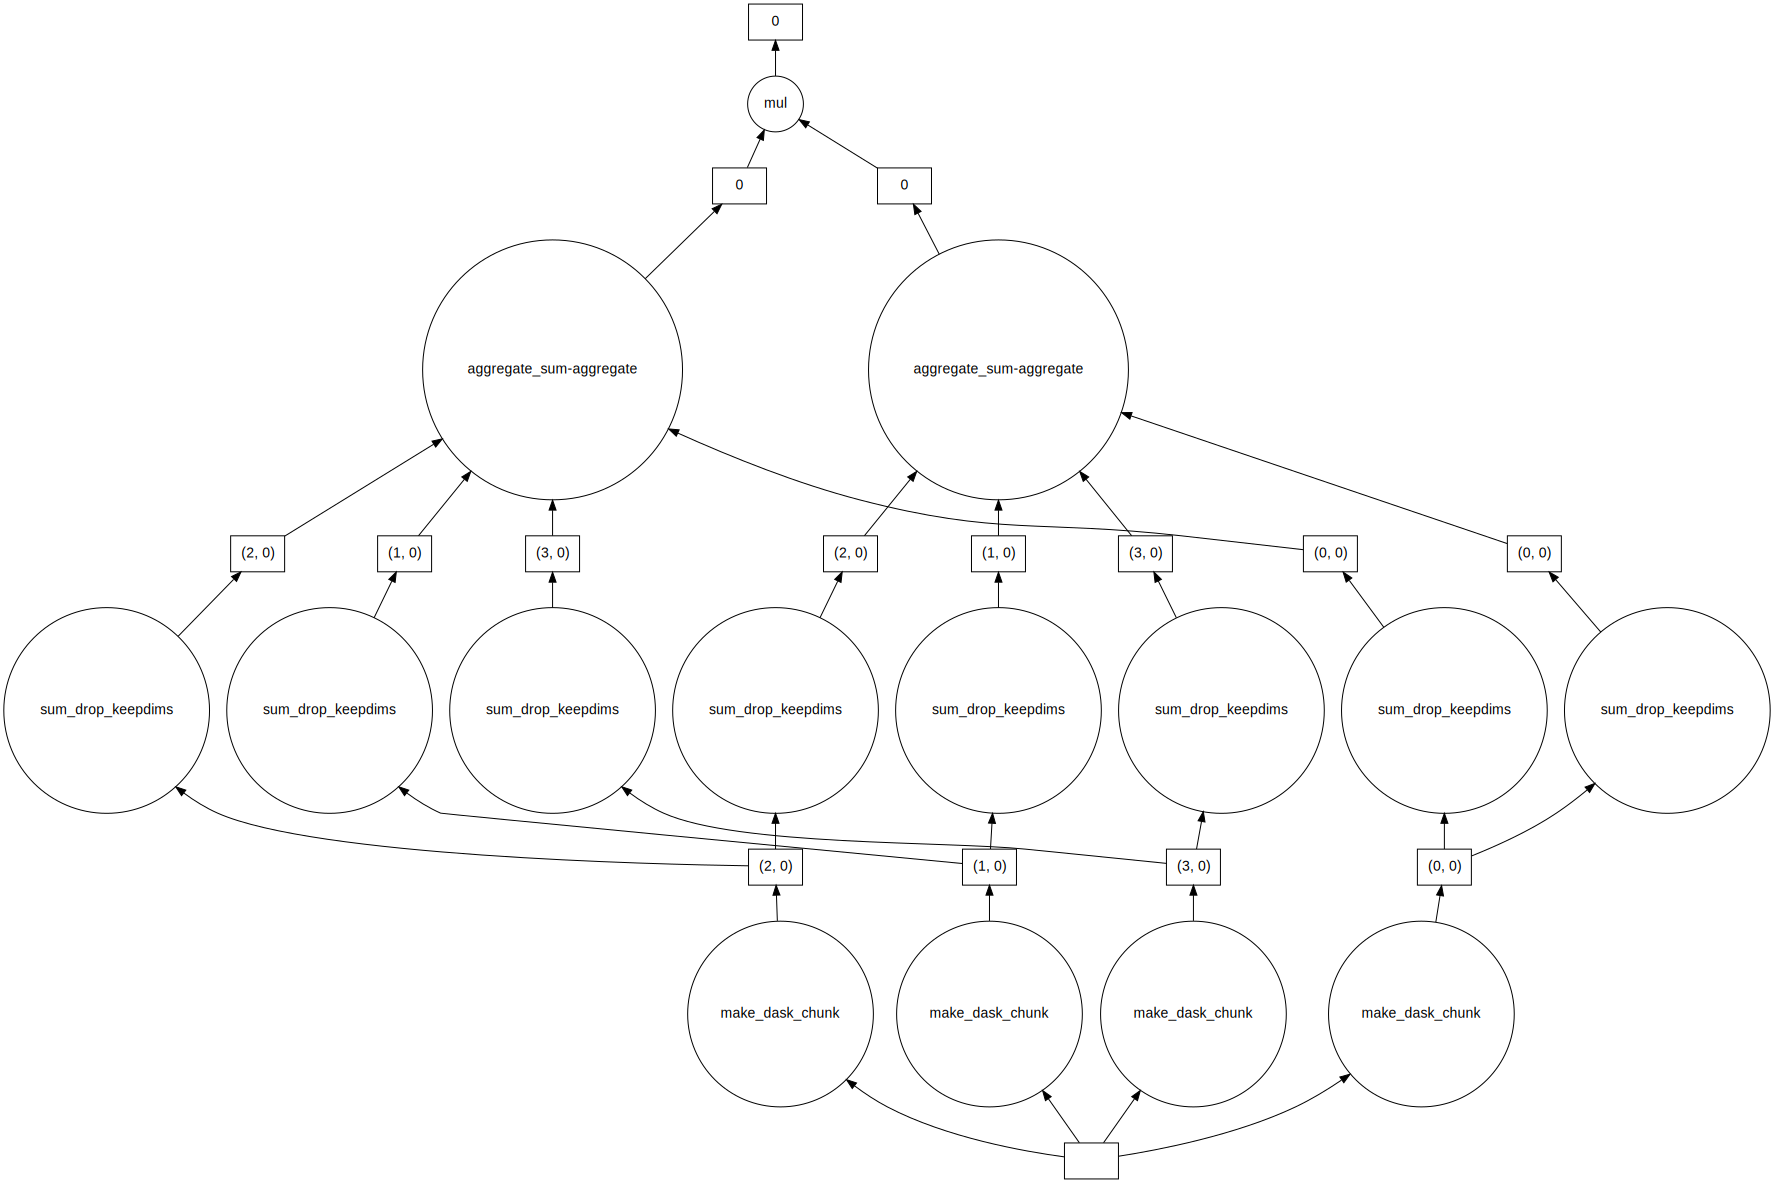

In [14]:
mv1.visualize(f'mean-var-{tissue}-h5ad.opt.svg', optimize_graph=True)

In [15]:
%%time
mv1c = mv1.compute()
mv1c

CPU times: user 749 ms, sys: 150 ms, total: 899 ms
Wall time: 20.8 s


array([2.37486496e+00, 1.78383347e-04, 2.47206989e-01, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])